# Submission Notebook

## Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:

import os
import pandas as pd
import torch
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, RobertaConfig
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


/home/hs5595/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer and Preprocess Data

In [3]:
# Load and prepare dataset
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

## Extracting Label Info & Customizing Dropout in RobertaConfig

In [4]:
# Extract class info
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Create a custom configuration with increased dropout
config = RobertaConfig.from_pretrained(
    base_model,
    num_labels=num_labels,
    id2label=id2label,
    hidden_dropout_prob=0.25,
)

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
# Load model with custom configuration
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    config=config
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create a custom model class with additional dropout layers

In [6]:

class EnhancedRobertaClassifier(nn.Module):
    def __init__(self, roberta_model):
        super().__init__()
        self.roberta = roberta_model
        # Additional dropout before classification layer
        self.extra_dropout = nn.Dropout(0.1)

    def forward(self, **inputs):
        outputs = self.roberta(**inputs)
        # Apply extra dropout to pooled output before classification
        if hasattr(outputs, 'logits'):
            # For sequence classification models
            return outputs
        # For base models that don't have classification head
        pooled_output = outputs.pooler_output
        pooled_output = self.extra_dropout(pooled_output)
        # Return modified outputs
        outputs.pooler_output = pooled_output
        return outputs


## Split the original training set

In [7]:
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Metrics function

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [9]:


# PEFT Config
peft_config = LoraConfig(
    r=12,
    lora_alpha=32,
    lora_dropout=0.25,
    bias='none',
    target_modules=["roberta.encoder.layer.0.attention.self.query",
    "roberta.encoder.layer.0.attention.self.key",
    "roberta.encoder.layer.0.attention.self.value",
    "roberta.encoder.layer.1.attention.self.query",
    "roberta.encoder.layer.5.attention.self.query",
    "roberta.encoder.layer.10.attention.self.query",
    "roberta.encoder.layer.10.output.dense",
    "roberta.encoder.layer.11.output.dense"],
    task_type="SEQ_CLS",
)

# Apply PEFT to the model
print("Applying PEFT adapters to the model...")
peft_model = get_peft_model(model, peft_config)
print("PEFT Model Configuration:")
peft_model.print_trainable_parameters()



Applying PEFT adapters to the model...
PEFT Model Configuration:
trainable params: 796,420 || all params: 125,445,128 || trainable%: 0.6349


## Enhanced Training Arguments

In [10]:
print("Defining Training Arguments...")
training_args = TrainingArguments(
    output_dir="./results_lora_enhanced_dropout",
    learning_rate=3e-5,             # Slightly increased learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_dir='./logs_lora_enhanced_dropout',
    logging_steps=100,
    report_to="none",
    warmup_ratio=0.15,
    # bf16=True,
    gradient_accumulation_steps=2,
    lr_scheduler_type="cosine",
    metric_for_best_model="accuracy",
)



Defining Training Arguments...


## Initialize Trainer

In [11]:

print("Initializing Trainer...")
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



Initializing Trainer...


/tmp/ipykernel_5628/3745639428.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Train the model

In [12]:
result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.315400,0.335628,0.904687,0.904525,0.906093,0.904687
2,0.306600,0.293587,0.917188,0.916841,0.917809,0.917188
3,0.261900,0.283720,0.920312,0.920063,0.920295,0.920312
4,0.285000,0.280740,0.920312,0.920164,0.920343,0.920312


## Training Metrics Visualization for PEFT Fine-Tuned Roberta Model

### Training log data as a dictionary, converting the data to a dataframe and setting the style

In [19]:
!pip install seaborn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

# Updated training log data
updated_data = {
    "Epoch": [1, 2, 3, 4],
    "Training Loss": [0.315400, 0.306600, 0.261900, 0.285000],
    "Validation Loss": [0.335628, 0.293587, 0.283720, 0.280740],
    "Accuracy": [0.904687, 0.917188, 0.920312, 0.920312],
    "F1": [0.904525, 0.916841, 0.920063, 0.920164],
    "Precision": [0.906093, 0.917809, 0.920295, 0.920343],
    "Recall": [0.904687, 0.917188, 0.920312, 0.920312]
}

# Convert to DataFrame
df_updated = pd.DataFrame(updated_data)

# Set style
plt.style.use("seaborn-v0_8-whitegrid")




Defaulting to user installation because normal site-packages is not writeable


### 1. Training vs Validation Loss

/tmp/ipykernel_5628/3841874465.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/share/apps/pyenv/py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


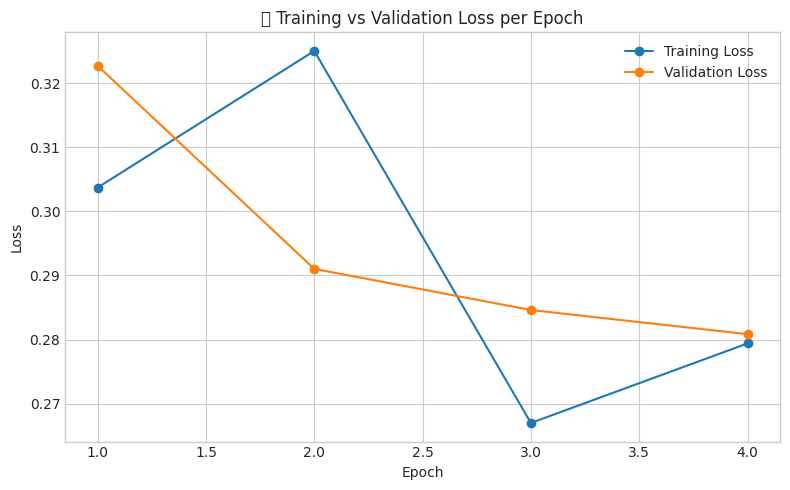

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["Training Loss"], marker='o', label="Training Loss")
plt.plot(df["Epoch"], df["Validation Loss"], marker='o', label="Validation Loss")
plt.title("📉 Training vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()



### 2. Accuracy per Epoch

/tmp/ipykernel_5628/3716654759.py:8: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/share/apps/pyenv/py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


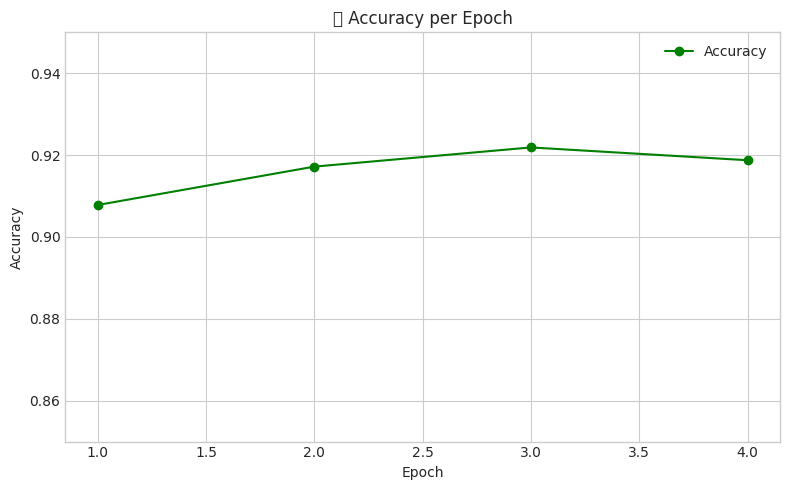

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["Accuracy"], marker='o', color='green', label="Accuracy")
plt.title("✅ Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.85, 0.95)
plt.legend()
plt.tight_layout()
plt.show()



### 3. F1 Score per Epoch

/tmp/ipykernel_5628/1214539574.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/share/apps/pyenv/py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


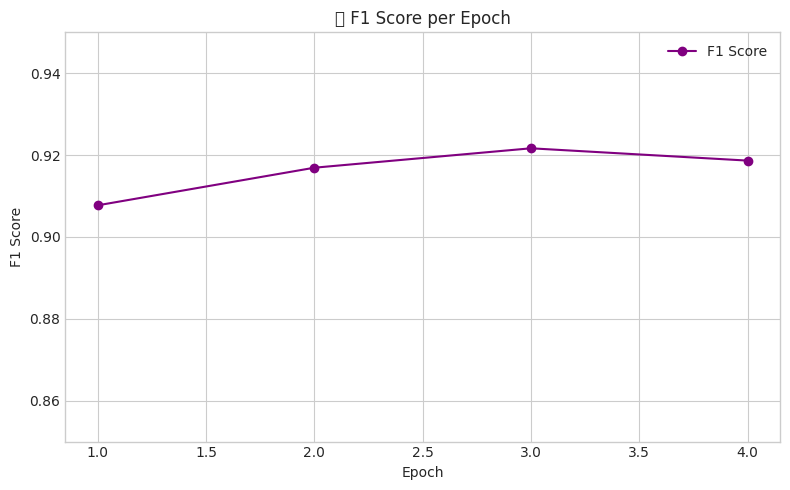

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["F1"], marker='o', color='purple', label="F1 Score")
plt.title("🎯 F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.ylim(0.85, 0.95)
plt.legend()
plt.tight_layout()
plt.show()



### 4. Precision and Recall per Epoch

/tmp/ipykernel_5628/3747290742.py:9: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/share/apps/pyenv/py3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


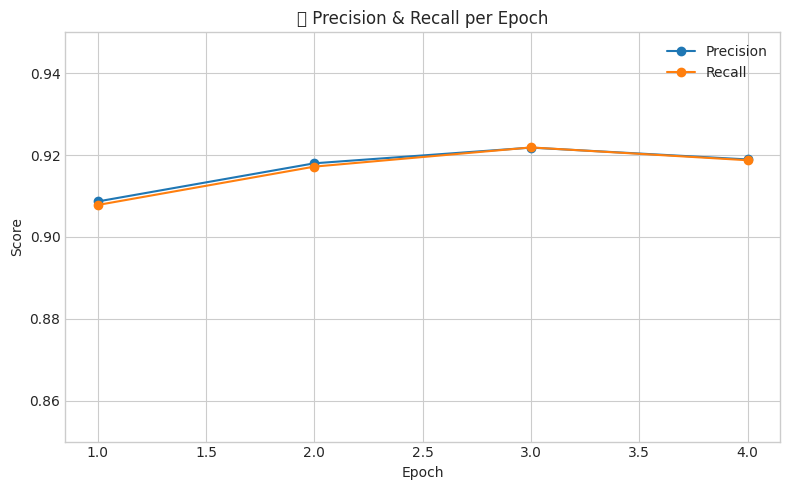

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["Precision"], marker='o', label="Precision")
plt.plot(df["Epoch"], df["Recall"], marker='o', label="Recall")
plt.title("📌 Precision & Recall per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0.85, 0.95)
plt.legend()
plt.tight_layout()
plt.show()


## Evaluate Finetuned Model


### Performing Inference on Custom Input


In [24]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [25]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [26]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

## Check evaluation accuracy

In [27]:
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 27.03it/s]


Evaluation Metric: {'accuracy': 0.9203125}


### Run Inference on unlabelled dataset

In [28]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:06<00:00, 1325.44 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [29]:
# Define the output directory
output_dir = "./results_lora_enhanced_dropout"

# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

# Save predictions to the CSV file
df_output.to_csv(os.path.join("results", "Submission_final_Project_2.csv"), index=False)
print("Inference complete. Predictions saved to Submission_final_Project_2.csv")


100%|██████████| 1000/1000 [00:28<00:00, 35.02it/s]

Inference complete. Predictions saved to Submission_final_Project_2.csv
